# Import Libraries

In [10]:
import warnings                                  # `do not disturb`
warnings.filterwarnings('ignore')
import pickle

import numpy as np                               # vectors and matrices
import pandas as pd                              # tables and data manipulations
import matplotlib.pyplot as plt                  # plots
import seaborn as sns                            # more plots

from dateutil.relativedelta import relativedelta # working with dates with style
from scipy.optimize import minimize              # for function minimization

import statsmodels.formula.api as smf            # statistics and econometrics
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs

from itertools import product                    # some useful functions
from tqdm import tqdm_notebook
import pickle
%matplotlib inline

from sklearn.metrics import r2_score, median_absolute_error, mean_absolute_error # Importing metrics
from sklearn.metrics import median_absolute_error, mean_squared_error, mean_squared_log_error

In [11]:
with open("./data/btc.pickle", 'rb') as f:
    btc = pickle.load(f)

In [12]:
btc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1956944 entries, 1514764860 to 1632181440
Data columns (total 9 columns):
 #   Column    Dtype  
---  ------    -----  
 0   Asset_ID  int64  
 1   Count     float64
 2   Open      float64
 3   High      float64
 4   Low       float64
 5   Close     float64
 6   Volume    float64
 7   VWAP      float64
 8   Target    float64
dtypes: float64(8), int64(1)
memory usage: 134.4 MB


# Functions

In [27]:
def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def moving_average(series, n=15):
    """
    Calculate average of last n observations
    """
    return np.average(series[-n:])

def weighted_average(series, weights):
    """
        Calculate weighted average on the series.
        Assuming weights are sorted in descending order
        (larger weights are assigned to more recent observations).
    """
    result = 0.0
    for n in range(len(weights)):
        result += series.iloc[-n-1] * weights[n]
    return float(result)

In [48]:
btc_mini = btc.copy()[-10000:]

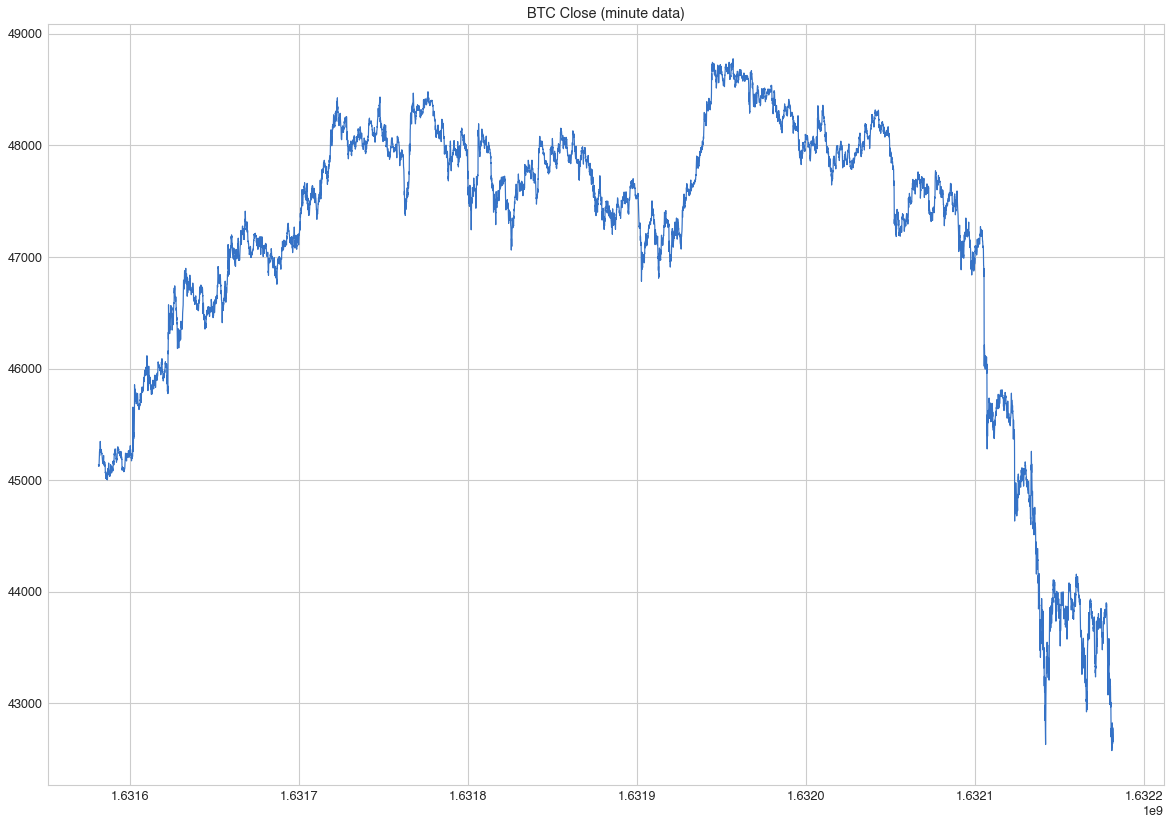

In [49]:
plt.figure(figsize=(20, 14))
plt.plot(btc_mini.Close)
plt.title('BTC Close (minute data)')
plt.grid(True)
plt.show()

# Exponential smoothing

In [269]:
def exponential_smoothing(series, alpha):
    """
        series - dataset with timestamps
        alpha - float [0.0, 1.0], smoothing parameter
    """
    values = series.values
    result = [values[0]] # first value is same as series
    for n in range(1, len(series)):
        result.append(alpha * values[n] + (1 - alpha) * result[n-1])
    return result

def plotExponentialSmoothing(series, window, alphas, plot_intervals = False, scale = 1.96, plot_anomalies=False):
    """
        Plots exponential smoothing with different alphas
        
        series - dataset with timestamps
        alphas - list of floats, smoothing parameters
        
    """  
    plt.figure(figsize=(15, 5))
    for alpha in alphas:
        plt.plot(exponential_smoothing(series, alpha), c="orange", label="Alpha {}".format(alpha))
    plt.plot(series.values, "b", label = "Actual")
    plt.title("Moving Exponential Average\n Window Size = {}".format(window))
    plt.legend(loc="best")
    plt.axis('tight')
    
    if plot_intervals:
        mae = mean_absolute_error(
            series, exponential_smoothing(series, alpha)
        )
        
        deviation = np.std(series - exponential_smoothing(series, alpha))
        lower_bound = exponential_smoothing(series, alpha) - (mae + scale * deviation)
        upper_bound = exponential_smoothing(series, alpha) + (mae + scale * deviation)
        plt.plot(upper_bound, "r--", label="Upper Bound / Lower Bound")
        plt.plot(lower_bound, "r--")
        
        # Having the intervals, find abnormal values
        if plot_anomalies:
            anomalies = pd.Series(index=series.index, name=series.name)
            anomalies[series<lower_bound] = series[series<lower_bound]
            print(str(len(anomalies[series<lower_bound])) + str(" lower-bound anomalies found"))
            anomalies[series>upper_bound] = series[series>upper_bound]
            print(str(len(anomalies[series<lower_bound])) + str(" upper-bound anomalies found"))
            plt.plot(anomalies, "black", markersize=10)
        
    plt.legend(loc="best")
    plt.grid(b=True)

(700,)
8 lower-bound anomalies found
8 upper-bound anomalies found


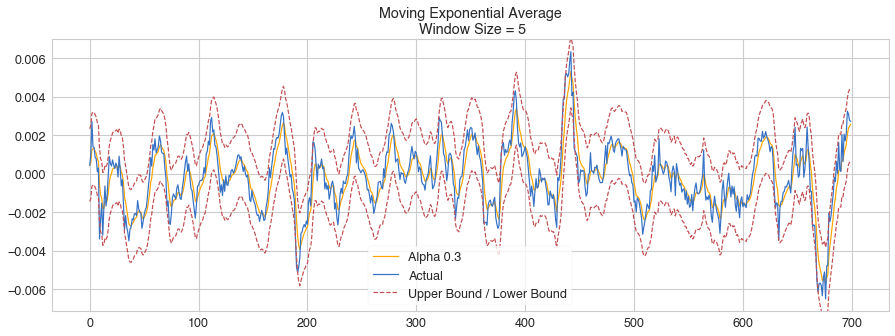

In [270]:
plotExponentialSmoothing(btc_mini.Target[-700:], window=5, alphas=[0.3], plot_intervals=True, scale=1.96, plot_anomalies=True)

(700,)
8 lower-bound anomalies found
8 upper-bound anomalies found


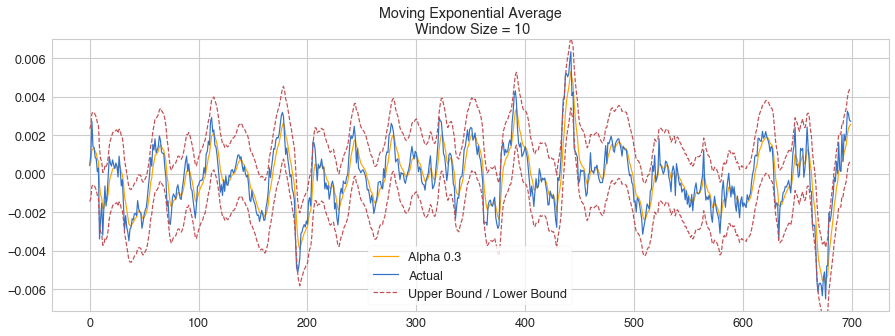

In [271]:
plotExponentialSmoothing(btc_mini.Target[-700:], window=10, alphas=[0.3], plot_intervals=True, scale=1.96, plot_anomalies=True)

(700,)
8 lower-bound anomalies found
8 upper-bound anomalies found


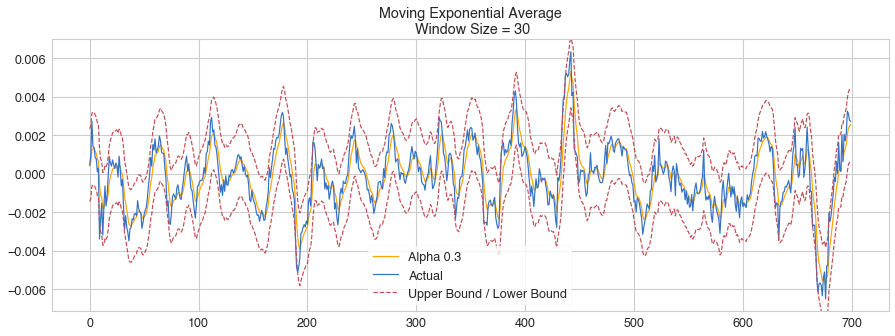

In [273]:
plotExponentialSmoothing(btc_mini.Target[-700:], window=30, alphas=[0.3], plot_intervals=True, scale=1.96, plot_anomalies=True)

(700,)
9 lower-bound anomalies found
9 upper-bound anomalies found


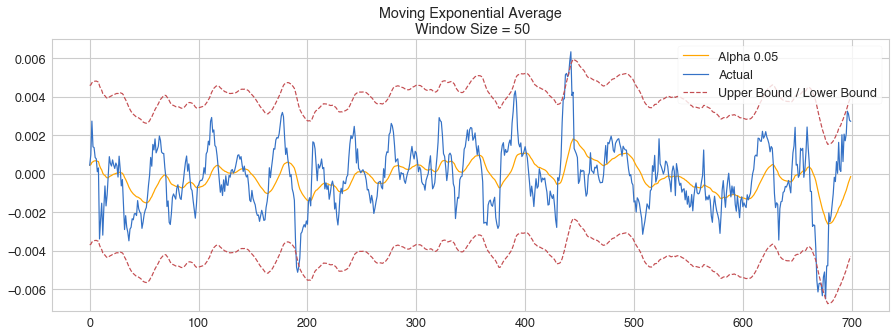

In [278]:
plotExponentialSmoothing(btc_mini.Target[-700:], window=50, alphas=[0.05], plot_intervals=True, scale=1.96, plot_anomalies=True)